<a href="https://colab.research.google.com/github/Farmhouse121/Financial-Data-Science-in-Python/blob/main/Alphas/Filter_Rules.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Investigation of Filter Rules
---
## Load useful packages...

In [9]:
from my_library import *

## Get S&P 500 Index Data from Yahoo! Finance

In [10]:
nprint("Fetching data from Yahoo!...")
data,sname=download(ticker:='SPY','1990-01-02','2019-12-31',auto_adjust=True,progress=False),'S&P 500 Index ETF'
data.columns=data.columns.get_level_values(0)
data.columns.name=ticker
data.index=pd.PeriodIndex(data.index,freq='B')
data['Return']=data['Close'].pct_change()*hundred
data.dropna(inplace=True)
display(data)

14:55:48 Fetching data from Yahoo!...


<ipython-input-10-eadee26bc247>:5: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  data.index=pd.PeriodIndex(data.index,freq='B')


SPY,Close,High,Low,Open,Volume,Return
Date,,,,,,
1993-02-01,24.700516,24.700516,24.543521,24.543521,480500,0.711284
1993-02-02,24.752851,24.770295,24.630744,24.683076,201300,0.211881
1993-02-03,25.014507,25.031951,24.770293,24.787737,529400,1.057073
1993-02-04,25.119164,25.171495,24.822618,25.101720,531500,0.418382
1993-02-05,25.101725,25.154056,24.962174,25.101725,492100,-0.069425
...,...,...,...,...,...,...
2019-12-23,297.810883,298.209539,297.662539,298.153914,52990000,0.152744
2019-12-24,297.820221,298.089067,297.514254,298.042722,20270000,0.003136
2019-12-26,299.405518,299.414798,298.200267,298.209519,30911200,0.532300


## Fit baseline AR(1) GJR-AGARCH(1,1) model

In [11]:
from arch.univariate import ARX
model = ARX(data['Return'],lags=1)
model.volatility = GARCH2(0,1,1)
model.distribution = GeneralizedError2()
fit=model.fit(update_freq=0,disp='off')
nprint(fit.summary(),sep='\n')
display(baseline:=pd.DataFrame([fit.params,fit.std_err]).T)
data['Volatility']=fit.conditional_volatility
data['Alpha']=baseline.loc['Const','params']+baseline.loc['Return[1]','params']*data['Return'].shift()
data['Z Score']=(data['Return']-data['Alpha'])/data['Volatility'].shift()
display(data)
nprint("Baseline IC %.2f %%." % (hundred*fit.rsquared**half))

14:55:48
                               AR - GJR-GARCH Model Results                               
Dep. Variable:                             Return   R-squared:                       0.003
Mean Model:                                    AR   Adj. R-squared:                  0.003
Vol Model:                              GJR-GARCH   Log-Likelihood:               -8759.18
Distribution:      Generalized Error Distribution   AIC:                           17530.4
Method:                        Maximum Likelihood   BIC:                           17571.3
                                                    No. Observations:                 6777
Date:                            Wed, Mar 19 2025   Df Residuals:                     6775
Time:                                    14:55:48   Df Model:                            2
                                  Mean Model                                  
                 coef    std err          t      P>|t|        95.0% Conf. Int.
--------------

,params,std_err
Const,0.062284,0.009140
Return[1],-0.037915,0.013205
omega,0.017251,0.003156
gamma[1],0.187390,0.021784
beta[1],0.888963,0.011779
nu,1.348239,0.036889


SPY,Close,High,Low,Open,Volume,Return,Volatility,Alpha,Z Score
Date,,,,,,,,,
1993-02-01,24.700516,24.700516,24.543521,24.543521,480500,0.711284,NaN,NaN,NaN
1993-02-02,24.752851,24.770295,24.630744,24.683076,201300,0.211881,0.783957,0.035316,NaN
1993-02-03,25.014507,25.031951,24.770293,24.787737,529400,1.057073,0.750732,0.054251,1.279180
1993-02-04,25.119164,25.171495,24.822618,25.101720,531500,0.418382,0.719910,0.022205,0.527721
1993-02-05,25.101725,25.154056,24.962174,25.101725,492100,-0.069425,0.691357,0.046421,-0.160917
...,...,...,...,...,...,...,...,...,...
2019-12-23,297.810883,298.209539,297.662539,298.153914,52990000,0.152744,0.484166,0.045661,0.216653
2019-12-24,297.820221,298.089067,297.514254,298.042722,20270000,0.003136,0.475015,0.056493,-0.110204
2019-12-26,299.405518,299.414798,298.200267,298.209519,30911200,0.532300,0.467300,0.062165,0.989727


14:55:48 Baseline IC 5.46 %.


## Fit a Basic "Filter Rules" Model

In [80]:
# create filter rules summary holder
from itertools import product
summary=pd.DataFrame({tuple(x):[] for x in product(['Active','Inactive'],['Mean','St.Dev.','Count','Std.Err.'])},index=pd.Series([],name='Filter'))

In [79]:
nprint("Creating filter rule indicators with order {:d} and offset {:f}.".format(forder:=1,foffset:=0.1))

data['Direction']=data['Z Score'].apply(lambda x: one if x>foffset else -one if x<-foffset else zero)
data.drop(data.columns[data.columns.str.contains('Filter')],axis=1,inplace=True)

for lag in range(1,forder+1):
    data['Z_'+str(lag)]=data['Z Score'].shift(lag)
    data['Direction_'+str(lag)]=data['Direction'].shift(lag)

for rule in range(2**forder):
    rmap=list(map(lambda x:-one if x=='0' else +one,label:="{:0#b}".replace("#",str(forder)).format(rule)))
    data['Filter_'+label]=(data['Direction_1']==rmap[0])

    for lag in range(2,forder+1):
        data['Filter_'+label]&=(data['Direction_'+str(lag)]==rmap[lag-1])

    data['Filter_'+label]=data['Filter_'+label].apply(lambda x:one if x else zero)

nprint("Conditional returns:")
display(data)

for f in data.columns[data.columns.str.contains('Filter')]:
    g=data[[f,'Return']].groupby(f)
    summary.loc[f,('Active','Mean')]=g.mean().loc[one,'Return']
    summary.loc[f,('Inactive','Mean')]=g.mean().loc[zero,'Return']
    summary.loc[f,('Active','St.Dev.')]=g.std().loc[one,'Return']
    summary.loc[f,('Inactive','St.Dev.')]=g.std().loc[zero,'Return']
    summary.loc[f,('Active','Count')]=g.count().loc[one,'Return']
    summary.loc[f,('Inactive','Count')]=g.count().loc[zero,'Return']

    for s in [c for c in set(summary.columns.get_level_values(0)) if c!='Z Score']:
        summary.loc[f,(s,'Std.Err.')]=summary.loc[f,(s,'St.Dev.')]/np.sqrt(summary.loc[f,(s,'Count')])

summary=summary[sorted(summary.columns)].copy()
summary['Z Score']=(summary['Active','Mean']-summary['Inactive','Mean'])/np.sqrt(summary['Active','Std.Err.']**two+summary['Inactive','Std.Err.']**two)
summary.index=list(map(lambda x:x.replace('Filter_','').replace('0','-').replace('1','+'),summary.index))
summary.index.name='Rule'
display(summary.sort_values('Z Score',ascending=False))

17:16:19 Creating filter rule indicators with order 5 and offset 0.100000.
17:16:19 Conditional returns:


SPY,Close,High,Low,Open,Volume,Return,Volatility,Alpha,Z Score,Direction,...,Filter_10110,Filter_10111,Filter_11000,Filter_11001,Filter_11010,Filter_11011,Filter_11100,Filter_11101,Filter_11110,Filter_11111
Date,,,,,,,,,,,,,,,,,,,,,
1993-02-01,24.700516,24.700516,24.543521,24.543521,480500,0.711284,NaN,NaN,NaN,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1993-02-02,24.752851,24.770295,24.630744,24.683076,201300,0.211881,0.783957,0.035316,NaN,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1993-02-03,25.014507,25.031951,24.770293,24.787737,529400,1.057073,0.750732,0.054251,1.279180,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1993-02-04,25.119164,25.171495,24.822618,25.101720,531500,0.418382,0.719910,0.022205,0.527721,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1993-02-05,25.101725,25.154056,24.962174,25.101725,492100,-0.069425,0.691357,0.046421,-0.160917,-1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-23,297.810883,298.209539,297.662539,298.153914,52990000,0.152744,0.484166,0.045661,0.216653,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-12-24,297.820221,298.089067,297.514254,298.042722,20270000,0.003136,0.475015,0.056493,-0.110204,-1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-12-26,299.405518,299.414798,298.200267,298.209519,30911200,0.532300,0.467300,0.062165,0.989727,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Active                               Inactive                      \
       Count      Mean   St.Dev.  Std.Err.    Count      Mean   St.Dev.   
Rule                                                                      
+-+--  131.0  0.233294  1.070917  0.093566   6647.0  0.039614  1.143348   
-----   90.0  0.517292  2.300063  0.242448   6688.0  0.036980  1.117485   
---+-  129.0  0.269626  1.398892  0.123166   6649.0  0.038968  1.136360   
-+++-  137.0  0.174201  0.866960  0.074069   6641.0  0.040659  1.147105   
+-+-+  115.0  0.145079  0.918112  0.085614   6663.0  0.041602  1.145689   
----+  124.0  0.195584  1.445490  0.129809   6654.0  0.040521  1.135753   
-+-+-  112.0  0.109374  1.025912  0.096940   6666.0  0.042249  1.144119   
++-+-  135.0  0.090582  0.889075  0.076519   6643.0  0.042398  1.146827   
+++--  133.0  0.087306  0.880621  0.076360   6645.0  0.042478  1.146890   
--++-  136.0  0.065403  1.265041  0.108476   6642.0  0.042906  1.139677   
+-+++  127.0  0.060920  0.988827  0.087744   6651.0  0.043022  1.145020   
--+--  140.0  0.065926  1.773371  0.149877   6638.0  0.042882  1.125315   
++---  150.0  0.037193  1.032984  0.084343   6628.0  0.043497  1.144651   
+--+-  141.0  0.027224  1.419247  0.119522   6637.0  0.043701  1.135741   
++-++  127.0  0.029404  0.938958  0.083319   6651.0  0.043624  1.145816   
++--+  142.0  0.027220  0.871602  0.073143   6636.0  0.043703  1.147371   
---++  138.0  0.017460  1.337327  0.113841   6640.0  0.043896  1.137931   
-+---  135.0  0.011363  1.472393  0.126723   6643.0  0.044008  1.134657   
-++--  138.0  0.018948  1.054117  0.089732   6640.0  0.043865  1.144056   
+--++  134.0  0.017517  1.073689  0.092753   6644.0  0.043879  1.143639   
--+++  125.0  0.015262  1.067342  0.095466   6653.0  0.043886  1.143658   
-+-++  119.0  0.013747  1.067653  0.097872   6659.0  0.043887  1.143586   
+-++-  119.0  0.005422  1.142710  0.104752   6659.0  0.044036  1.142295   
+----  130.0 -0.009875  1.310833  0.114968   6648.0  0.044399  1.138771   
-++-+  109.0 -0.013463  1.165436  0.111628   6669.0  0.044286  1.141911   
--+-+  120.0 -0.043457  1.179030  0.107630   6658.0  0.044922  1.141586   
+++++   80.0 -0.091331  1.239959  0.138632   6698.0  0.044966  1.141015   
+---+  152.0 -0.064444  1.189059  0.096445   6626.0  0.045831  1.141106   
+++-+  134.0 -0.060005  1.035416  0.089446   6644.0  0.045442  1.144255   
-++++  109.0 -0.077830  0.996084  0.095408   6669.0  0.045339  1.144421   
++++-  128.0 -0.082733  0.755373  0.066766   6650.0  0.045785  1.148300   
-+--+  138.0 -0.237709  1.283407  0.109251   6640.0  0.049199  1.138482   

                  Z Score  
       Std.Err.            
Rule                       
+-+--  0.014024  2.047104  
-----  0.013664  1.977955  
---+-  0.013936  1.860878  
-+++-  0.014076  1.771240  
+-+-+  0.014036  1.192719  
----+  0.013923  1.187737  
-+-+-  0.014013  0.685321  
++-+-  0.014071  0.619311  
+++--  0.014069  0.577351  
--++-  0.013984  0.205682  
+-+++  0.014040  0.201409  
--+--  0.013812  0.153102  
++---  0.014060 -0.073733  
+--+-  0.013941 -0.136925  
++-++  0.014050 -0.168301  
++--+  0.014085 -0.221288  
---++  0.013965 -0.230492  
-+---  0.013921 -0.256065  
-++--  0.014040 -0.274343  
+--++  0.014031 -0.281022  
--+++  0.014021 -0.296652  
-+-++  0.014014 -0.304842  
+-++-  0.013998 -0.365371  
+----  0.013967 -0.468633  
-++-+  0.013983 -0.513329  
--+-+  0.013991 -0.814293  
+++++  0.013942 -0.978229  
+---+  0.014018 -1.131503  
+++-+  0.014038 -1.164639  
-++++  0.014014 -1.277267  
++++-  0.014081 -1.883452  
-+--+  0.013971 -2.604930

16:43:32 Fitting GJR-GARCH model with filter rules...
16:43:32
                              AR-X - GJR-GARCH Model Results                              
Dep. Variable:                             Return   R-squared:                       0.002
Mean Model:                                  AR-X   Adj. R-squared:                  0.001
Vol Model:                              GJR-GARCH   Log-Likelihood:               -8751.07
Distribution:      Generalized Error Distribution   AIC:                           17528.1
Method:                        Maximum Likelihood   BIC:                           17616.8
                                                    No. Observations:                 6773
Date:                            Wed, Mar 19 2025   Df Residuals:                     6764
Time:                                    16:43:32   Df Model:                            9
                                   Mean Model                                  
                  coef    std err     

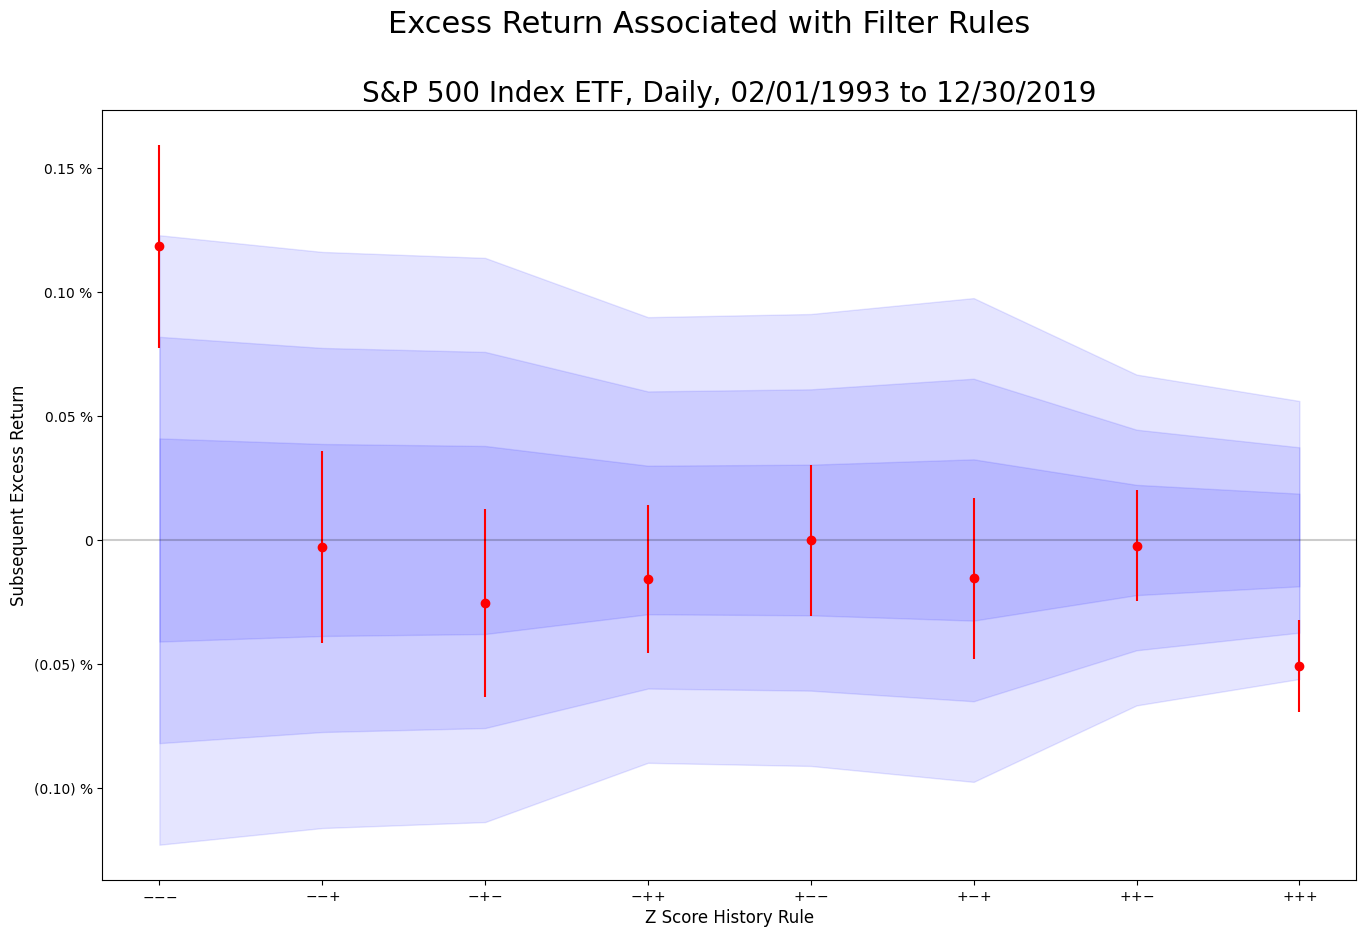

In [35]:
nprint("Fitting GJR-GARCH model with filter rules...")
model=ARX((design:=data.dropna())['Return'],design[fcols:=design.columns[design.columns.str.contains('Filter')]])
model.volatility=GARCH2(0,1,1)
model.distribution=GeneralizedError2()
fit=model.fit(update_freq=0,disp='off')
nprint(fit.summary(),sep='\n')
coefficients=pd.DataFrame([fit.params[fcols],fit.std_err[fcols]]).T

figure,plot=pl.subplots(figsize=(ten*GoldenRatio,ten))
plot.errorbar(x:=list(map(lambda l:l.replace('Filter_','').replace('0','$-$').replace('1','$+$'),coefficients.index)),y:=coefficients['params'],ye:=coefficients['std_err'],fmt='o',color='red')
plot.axhline(color='black',alpha=0.2)
plot.set_ylabel('Subsequent Excess Return',fontsize=12)
plot.yaxis.set_major_formatter(PercentLabels(2))
plot.set_xlabel('Z Score History Rule',fontsize=12)
figure.suptitle(title:='Excess Return Associated with Filter Rules',fontsize=22)
plot.set_title(subtitle:='{:s}, Daily, {:s} to {:s}'.format(sname,data.index[0].strftime("%m/%d/%Y"),data.index[-1].strftime("%m/%d/%Y")),fontsize=20)

for s in range(1,4):
    plot.fill_between(x,-s*ye,y2=s*ye,alpha=0.1,color='blue')

figure.savefig(filename:=(filepath:='/content/drive/MyDrive/')+title+'.png',dpi=300,bbox_inches='tight')
nprint("Saved figure to '{:s}'.".format(filename))

### Fit a Conditional Model to (Filter_000 | Filter_111)

In [ ]:
nprint("Fitting a hybrid conditional autoregression...")
data['Conditional']=(data['Filter_000'].astype(bool)|data['Filter_111'].astype(bool)).astype(float)*data['Return'].shift()
model=ARX((design:=data.dropna())['Return'],design['Conditional'])
model.volatility=GARCH2(0,1,1)
model.distribution=GeneralizedError2()
fit=model.fit(update_freq=0,disp='off')
nprint(fit.summary(),sep='\n')
nprint("In-sample IC is (%.2f +/- %.2f) %%" % (-data[['Return','Conditional']].replace(zero,np.nan).dropna().corr().iloc[0,1]*hundred,hundred/np.sqrt(data[['Return','Conditional']].replace(zero,np.nan).dropna().shape[0]-three)))

Active                               Inactive                      \
            Count      Mean   St.Dev.  Std.Err.    Count      Mean   St.Dev.   
Filter                                                                         
Filter_000  590.0  0.206878  1.566588  0.064495   6188.0  0.027767  1.092095   
Filter_001  642.0  0.053381  1.297861  0.051222   6136.0  0.042309  1.124816   
Filter_010  620.0 -0.016513  1.187712  0.047700   6158.0  0.049386  1.137474   
Filter_011  604.0  0.031709  0.981937  0.039954   6174.0  0.044497  1.156782   
Filter_100  669.0 -0.010810  1.254634  0.048507   6109.0  0.049290  1.129194   
Filter_101  598.0  0.102462  1.025833  0.041949   6180.0  0.037639  1.152783   
Filter_110  671.0  0.055102  0.928622  0.035849   6107.0  0.042067  1.163367   
Filter_111  586.0 -0.031904  0.921587  0.038070   6192.0  0.050480  1.160749   

                       Z Score  
            Std.Err.            
Filter                          
Filter_000  0.013883  2.714932  
Filter_001  0.014359  0.208131  
Filter_010  0.014495 -1.321839  
Filter_011  0.014722 -0.300341  
Filter_100  0.014447 -1.187434  
Filter_101  0.014664  1.458728  
Filter_110  0.014887  0.335805  
Filter_111  0.014751 -2.017820

Empty DataFrame
Columns: [(Active, Mean), (Active, St.Dev.), (Inactive, Mean), (Inactive, St.Dev.)]
Index: []

In [66]:
summary.index[~summary.index.duplicated('last')]

Index(['-', '+', '--', '-+', '+-', '++'], dtype='object', name='Rule')